# 📊 Round Robin Benchmark Analysis

This notebook loads the latest benchmark results from:

`src/ai/statistics/round_robin_results/*.csv`

and computes winrates, matchup charts, damage statistics, and NEAT-style metrics.

In [128]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook working directory
CWD = Path().resolve()

# Walk upward until we find the project root (folder containing `src/`)
while CWD != CWD.root and not (CWD / "src").exists():
    CWD = CWD.parent

PROJECT_ROOT = CWD
print("Detected project root:", PROJECT_ROOT)

RESULTS_DIR = PROJECT_ROOT / "src/ai/statistics/round_robin_results"
print("Using results dir:", RESULTS_DIR)

csv_files = sorted(RESULTS_DIR.glob("round_robin_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {RESULTS_DIR}")

latest_csv = csv_files[-1]
print("📄 Loading:", latest_csv)

df = pd.read_csv(latest_csv)
df.head()

Detected project root: /home/cillard/projects/Game
Using results dir: /home/cillard/projects/Game/src/ai/statistics/round_robin_results
📄 Loading: /home/cillard/projects/Game/src/ai/statistics/round_robin_results/round_robin_20251209_181247.csv


,agentA,agentB,winner,turns,avg_turn_time_A,avg_turn_time_B,initial_unit_count_team1,initial_unit_count_team2,alive1,alive2,max_hp_team1,max_hp_team2,hp1,hp2
0,NEATAgent,MCTS_default,1.0,22,0.061463,0.242657,4,4,4.0,0.1,405,425,158,1
1,NEATAgent,MCTS_fast,NaN,30,0.062704,0.162650,4,4,3.0,1.0,410,370,161,2
2,NEATAgent,MCTS_fast,NaN,30,0.043469,0.190673,4,4,1.0,2.0,280,355,1,99
3,NEATAgent,MCTS_default,1.0,24,0.063130,0.252988,4,4,4.0,0.1,410,440,206,1
4,NEATAgent,MCTS_deep,1.0,18,0.121682,0.399229,4,3,4.0,0.1,420,300,224,1


Agent Timing Info

In [129]:
# Convert match rows into per-agent timing rows
rows = []

for _, r in df.iterrows():
    rows.append(
        {
            "agent": r["agentA"],
            "avg_turn_time": r["avg_turn_time_A"],
        }
    )
    rows.append(
        {
            "agent": r["agentB"],
            "avg_turn_time": r["avg_turn_time_B"],
        }
    )

df_agents = pd.DataFrame(rows)
df_agents.head()

,agent,avg_turn_time
0,NEATAgent,0.061463
1,MCTS_default,0.242657
2,NEATAgent,0.062704
3,MCTS_fast,0.162650
4,NEATAgent,0.043469


In [130]:
agent_time = (
    df_agents.groupby("agent")["avg_turn_time"]
    .mean()
    .sort_values()
    .to_frame("mean_turn_time")
)

agent_time

,mean_turn_time
agent,
NEATAgent,0.062929
MCTS_fast,0.205322
MCTS_default,0.245974
MCTS_deep,0.385108
Minimax_default,1.618567
Minimax_wide,3.144633
Minimax_deep,4.347477


/tmp/ipykernel_6439/1317440737.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


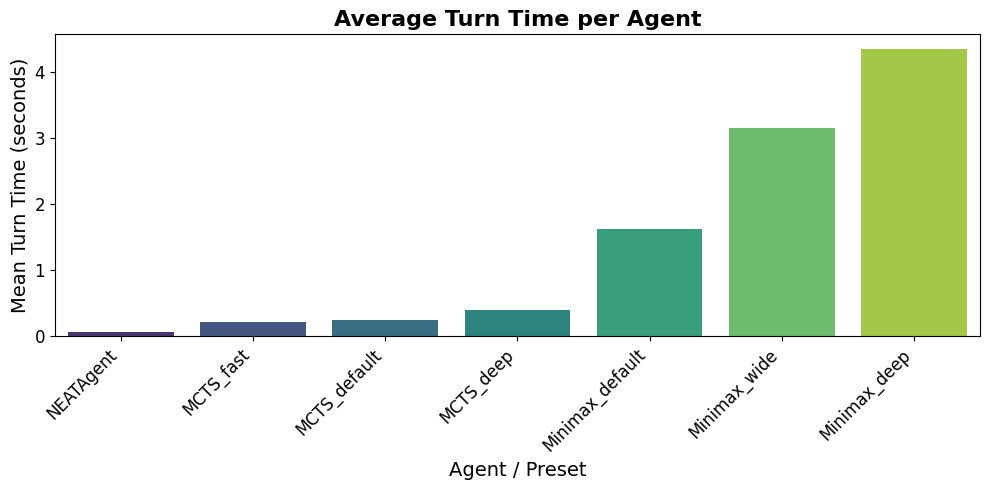

In [131]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=agent_time.reset_index(), x="agent", y="mean_turn_time", palette="viridis"
)

plt.title("Average Turn Time per Agent", fontsize=16, fontweight="bold")
plt.ylabel("Mean Turn Time (seconds)", fontsize=14)
plt.xlabel("Agent / Preset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Does deeper minimax explode turn time?

In [132]:
minimax_rows = agent_time[agent_time.index.str.contains("Minimax")]

print("🧠 Minimax Compute Cost Comparison:")
minimax_rows

🧠 Minimax Compute Cost Comparison:


,mean_turn_time
agent,
Minimax_default,1.618567
Minimax_wide,3.144633
Minimax_deep,4.347477


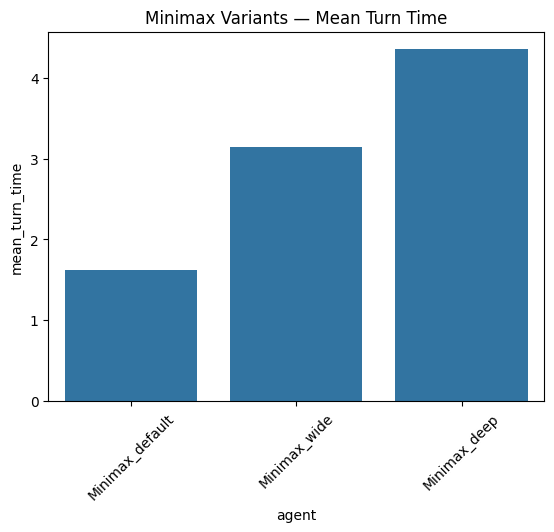

In [133]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=minimax_rows.index, y=minimax_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.title("Minimax Variants — Mean Turn Time")
plt.show()

Is MCTS rollout parameter affecting compute cost?

In [134]:
mcts_rows = agent_time[agent_time.index.str.contains("MCTS")]

print("🌲 MCTS Compute Cost Comparison:")
mcts_rows

🌲 MCTS Compute Cost Comparison:


,mean_turn_time
agent,
MCTS_fast,0.205322
MCTS_default,0.245974
MCTS_deep,0.385108


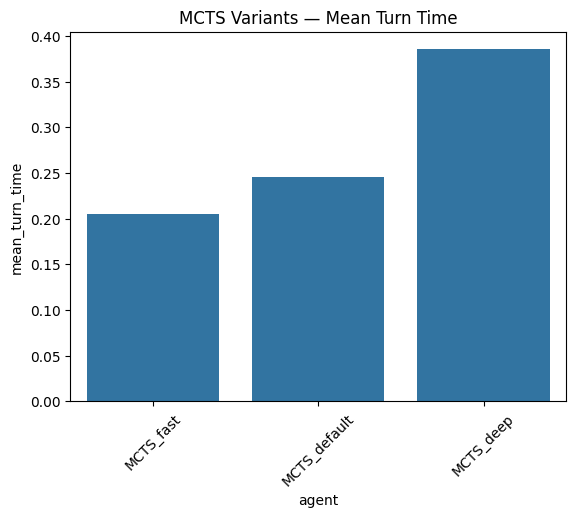

In [135]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=mcts_rows.index, y=mcts_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.title("MCTS Variants — Mean Turn Time")
plt.show()

## 🧮 Winrate Summary

In [136]:
agents = sorted(set(df["agentA"]) | set(df["agentB"]))

# Collect stats
win_stats = {a: {"wins": 0, "games": 0, "time_sum": 0.0} for a in agents}

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]

    # --- Agent A ---
    win_stats[A]["games"] += 1
    win_stats[A]["time_sum"] += row["avg_turn_time_A"]
    if winner == 1:
        win_stats[A]["wins"] += 1

    # --- Agent B ---
    win_stats[B]["games"] += 1
    win_stats[B]["time_sum"] += row["avg_turn_time_B"]
    if winner == 2:
        win_stats[B]["wins"] += 1

# Build summary table
summary = pd.DataFrame(
    [
        {
            "agent": agent,
            "winrate": win_stats[agent]["wins"] / win_stats[agent]["games"],
            "avg_turn_time": win_stats[agent]["time_sum"] / win_stats[agent]["games"],
        }
        for agent in agents
    ]
).set_index("agent")

summary

,winrate,avg_turn_time
agent,,
MCTS_deep,0.041667,0.385108
MCTS_default,0.041667,0.245974
MCTS_fast,0.041667,0.205322
Minimax_deep,0.166667,4.347477
Minimax_default,0.416667,1.618567
Minimax_wide,0.208333,3.144633
NEATAgent,0.291667,0.062929


## 🔥 Head-to-Head Winrate Matrix

In [137]:
matrix = pd.DataFrame(0.0, index=agents, columns=agents)

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    if winner == 1:
        matrix.loc[A, B] += 1
    elif winner == 2:
        matrix.loc[B, A] += 1

games_matrix = df.groupby(["agentA", "agentB"]).size().unstack(fill_value=0)

winrate_matrix = matrix.div(games_matrix + games_matrix.T, fill_value=0)
winrate_matrix

,MCTS_deep,MCTS_default,MCTS_fast,Minimax_deep,Minimax_default,Minimax_wide,NEATAgent
MCTS_deep,NaN,0.00,0.25,0.00,0.0,0.00,0.00
MCTS_default,0.00,NaN,0.00,0.00,0.0,0.25,0.00
MCTS_fast,0.25,0.00,NaN,0.00,0.0,0.00,0.00
Minimax_deep,0.25,0.00,0.25,NaN,0.0,0.25,0.25
Minimax_default,0.50,0.25,0.50,0.50,NaN,0.25,0.50
Minimax_wide,0.50,0.00,0.25,0.00,0.5,NaN,0.00
NEATAgent,0.75,0.75,0.00,0.25,0.0,0.00,NaN


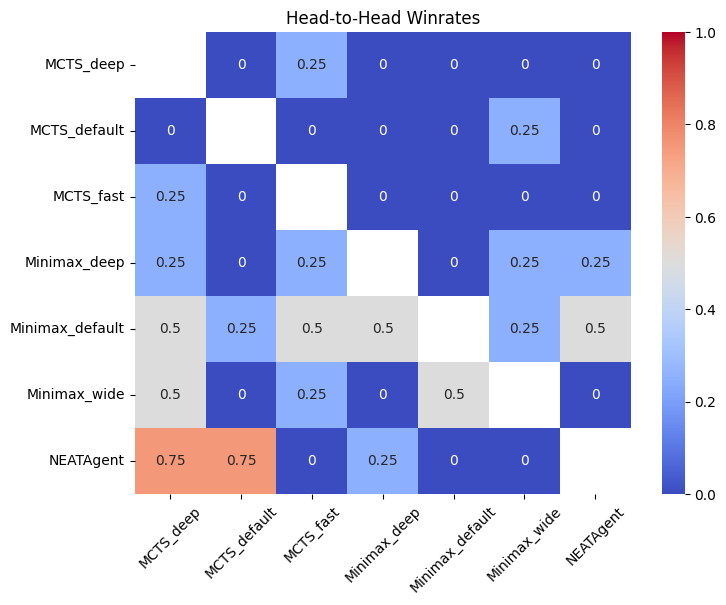

In [138]:
plt.figure(figsize=(8, 6))
sns.heatmap(winrate_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.xticks(rotation=45)
plt.title("Head-to-Head Winrates")
plt.show()

## Turn Time Winrate Correlation

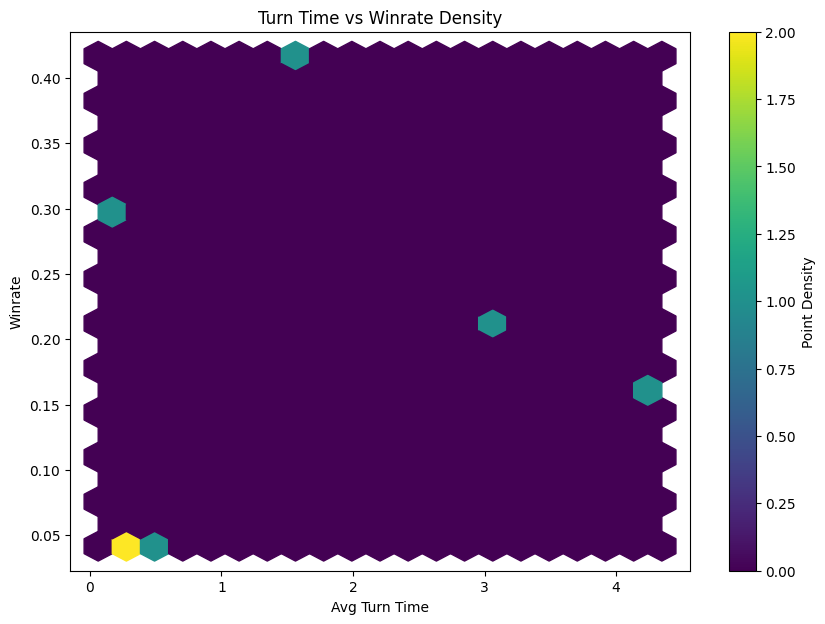

In [ ]:
plt.figure(figsize=(10, 7))

sns.stripplot(
    data=summary.reset_index(),
    x="avg_turn_time",
    y="winrate",
    jitter=0.25,
    size=12,
)

for agent, row in summary.iterrows():
    plt.text(
        row["avg_turn_time"] + 0.002,  # slight offset
        row["winrate"] + 0.005,
        str(agent),
        fontsize=10,
        ha="left",
    )

plt.title("Benchmark Agent Comparison — Time vs Winrate")
plt.xlabel("Average Turn Time (seconds)")
plt.ylabel("Winrate")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

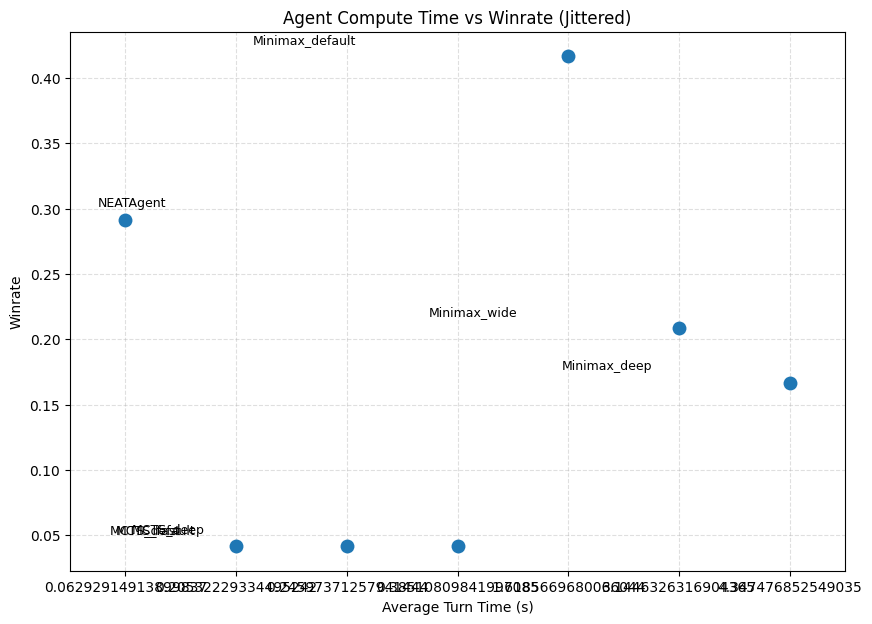

In [140]:
plt.figure(figsize=(10, 7))

sns.stripplot(
    data=summary.reset_index(),
    x="avg_turn_time",
    y="winrate",
    jitter=0.25,
    size=10,
)

for agent, row in summary.iterrows():
    plt.text(
        row["avg_turn_time"], row["winrate"] + 0.01, str(agent), fontsize=9, ha="center"
    )

plt.title("Agent Compute Time vs Winrate (Jittered)")
plt.xlabel("Average Turn Time (s)")
plt.ylabel("Winrate")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

## ⛑️ Survival Ratio

In [141]:
# Compute alive ratio per agent from stats
alive_rows = []

for _, r in df.iterrows():
    alive_rows.append(
        {
            "agent": r["agentA"],
            "alive_ratio": r["alive1"] / max(1, r["initial_unit_count_team1"]),
        }
    )
    alive_rows.append(
        {
            "agent": r["agentB"],
            "alive_ratio": r["alive2"] / max(1, r["initial_unit_count_team2"]),
        }
    )

df_alive = pd.DataFrame(alive_rows)
agent_alive = df_alive.groupby("agent")["alive_ratio"].mean().to_frame("alive_ratio")

agent_alive

,alive_ratio
agent,
MCTS_deep,0.271181
MCTS_default,0.437500
MCTS_fast,0.426042
Minimax_deep,0.570139
Minimax_default,0.637500
Minimax_wide,0.519792
NEATAgent,0.561458
